# Regional Tasmanian domain forced by JRA55-do reanalysis and ACCESS-OM2-01 model output

## What does this recipe do?
This recipe uses `regional-mom6` package to set up a regional ocean configuration with MOM6. The recipe uses input from: 

Input Type | Source | Location on NCI
---|---|---
Surface | [JRA55-do surface forcing](https://climate.mri-jma.go.jp/pub/ocean/JRA55-do/) | `/g/data/ik11`
Ocean | [ACCESS-OM2-01](https://github.com/COSIMA/access-om2) |  `/g/data/ik11`  
Bathymetry | [GEBCO](https://www.gebco.net/data_and_products/gridded_bathymetry_data/) | `/g/data/ik11`

Additionally to access to project `ik11`, you also need access to `/g/data/x77` if you want to use the same executable using the latest FMS build (a good idea for troubleshooting).

In [1]:
import intake
import xarray as xr
import os
import subprocess
import matplotlib.pyplot as plt
from pathlib import Path
from dask.distributed import Client

import regional_mom6 as rmom6
print("using regional-mom6 version " + rmom6.__version__)

using regional-mom6 version 1.0.1


Start a dask client.

In [2]:
client = Client(threads_per_worker = 1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38881,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:39841,Total threads: 1
Dashboard: /proxy/45025/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:34401,


## What does the `regional-mom6` package do?

Setting up a regional model in MOM6 can be a pain. The goal of this package is that users should spend their debugging time fixing a model that's running and doing weird things, rather than puzzling over a model that won't even start.

This notebook will guide you to configure a running MOM6 regional model. There will still be a lot of fiddling to do with the `MOM_input` file to make sure that the parameters are set up right for your domain, and you might want to manually edit some of the input files. *But*, `regional-mom6` package should help you bypass most of the woes of regridding, encoding and understanding the arcane arts of the MOM6 boundary segment files.

Wanna find out more about `regional-mom6` package? Go to the [package's documentation](https://regional-mom6.readthedocs.io/en/latest/).

### Citing

If you use regional-mom6 package in research, teaching, or other activities, we would be grateful if you could mention regional-mom6 and cite the paper in JOSS:

> Barnes et al. (2024). regional-mom6: A Python package for automatic generation of regional configurations for the Modular Ocean Model 6. _Journal of Open Source Software_, **9(100)**, 6857, doi:[10.21105/joss.06857](https://doi.org/0.21105/joss.06857).

## What does this recipe do?

This recipe demonstrates how to set up a regional domain using the package. By the end you should have a running MOM6 experiment on the domain of your choice. To make a stable test case:

* Avoid any regions with ice
* Avoid regions near the North pole

Also note, that although the default configuration is meant to be repeat-year forced (RYF), the calendar and encoding will need fixing to run longer than a year.

Input Type | Source
---|---
Surface | JRA55-do
Ocean | ACCESS-OM2-01
Bathymetry | Gebco

## Step 0: Your personal environment variables

Some user-custom directories are automatically sourced from the user's environment variables below.

In [3]:
scratch = subprocess.run("echo /scratch/$PROJECT/$USER", shell=True, capture_output=True, text=True).stdout.strip()
home = subprocess.run("echo ~", shell=True, capture_output=True, text=True).stdout.strip()

for (dir_name, dir) in zip(("scratch", "home"), (scratch, home)):
    print(dir_name, "directory:", dir)

scratch directory: /scratch/x77/nc3020
home directory: /home/552/nc3020


Users can override the paths that were sourced above from their enviroment variables by redefining a directory as a string. For example:

```python
scratch = "/scratch/ab12/xz1234/my_custom_directory_for_this_experiment"
```

## Step 1: Choose our domain, define workspace paths

To make sure that things are working I'd recommend starting with the default example defined below. If this runs ok, then change to a domain of your choice and hopefully it runs ok too! If not, check the [README](https://github.com/COSIMA/regional-mom6/blob/main/README.md) and [documentation](https://regional-mom6.readthedocs.io/) for troubleshooting tips.

You can log in and use [Copernicus GUI](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/download) to find the latitude-longitude ranges of the domain of choice and then paste below.

In [4]:
expt_name = "tassie-access-om2-forced"

latitude_extent = [-48, -38.95]
longitude_extent = [143, 150]

date_range = ["2013-01-01", "2013-01-05"]

## Place where all the input files go
input_dir = f"{scratch}/regional_mom6_configs/{expt_name}/"

## Directory where we'll be running the experiment from
run_dir = f"{home}/mom6_rundirs/{expt_name}/"

## Directory where the compiled FRE tools are located (needed to construct mask tables)
fre_tools_dir = "/g/data/ik11/mom6_tools/tools"

## Directory where ocean model cut-outs go before processing
tmp_dir = f"{scratch}/{expt_name}"

## if directories don't exist, create them
for path in (run_dir, tmp_dir, input_dir):
    os.makedirs(str(path), exist_ok=True)

## Step 2: Prepare ocean forcing data

We need to cut out our ocean forcing. The pipeline expects an initial condition and one time-dependent segment per non-land boundary. Naming convention is `"east_unprocessed"` and `"ic_unprocessed"` for initial condition. The following provides an example for cutting out the necessary forcing files from an ocean model. We use data from a Repeat-Year Forced ACCESS-OM2-01 experiment, but you should be able to recycle parts of the code to cut out data from a dataset of your choice.

We load the ACCESS-OM2-01 output using the Intake catalog. Note that load a slightly bigger region than our indented regional configuration (see `buffer` parameter below). This buffer-region enables proper interpolation of the ACCESS-OM2-01 output to the grid required by MOM6 near the regional domain's boundary.

First we load the default ACCESS-NRI intake catalog:

In [5]:
catalog = intake.cat.access_nri

And now we can load the desired ACCESS-OM2-01 model output that we'll use as boundary forcing and initial condition.

In [6]:
buffer = 0.2 # degrees; buffer around the regional domain used for interpolation -- try 2x the input's resolution

print('Open dataset...')
experiment = catalog["01deg_jra55v150_iaf_cycle1"]

ds_dict = experiment.search(
    variable=["u", "v", "salt", "temp", "eta_t"],
    frequency='1day',
    start_date=date_range[0]+", 00:00:00",
    
).to_dataset_dict()

access_om2_input = xr.merge(ds_dict.values(), join="inner")

access_om2_input = access_om2_input.sel(
        yu_ocean = slice(latitude_extent[0] - buffer, latitude_extent[1] + buffer),
        yt_ocean = slice(latitude_extent[0] - buffer, latitude_extent[1] + buffer))

access_om2_input = access_om2_input.sel(time=slice(date_range[0], date_range[1]))
access_om2_input

Open dataset...

--> The keys in the returned dictionary of datasets are constructed as follows:
	'file_id.frequency'


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(url, **xarray_open_kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/intake_esm/source.py:82: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTi

<xarray.Dataset> Size: 3GB
Dimensions:   (xt_ocean: 3600, yt_ocean: 131, time: 5, st_ocean: 75,
               xu_ocean: 3600, yu_ocean: 131)
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 1kB -48.19 -48.13 -48.06 ... -38.87 -38.79
  * time      (time) datetime64[ns] 40B 2013-01-01T12:00:00 ... 2013-01-05T12...
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * xu_ocean  (xu_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.8 79.9 80.0
  * yu_ocean  (yu_ocean) float64 1kB -48.16 -48.09 -48.03 ... -38.83 -38.75
Data variables:
    eta_t     (time, yt_ocean, xt_ocean) float32 9MB dask.array<chunksize=(1, 131, 720), meta=np.ndarray>
    temp      (time, st_ocean, yt_ocean, xt_ocean) float32 707MB dask.array<chunksize=(1, 19, 117, 180), meta=np.ndarray>
    u         (time, st_ocean, yu_ocean, xu_ocean) float32 707MB dask.array<chunksize=(1, 19, 117, 180), meta=np.ndarray>
    salt      (time, st_ocean, yt_ocean, xt_ocean) float32 707MB dask.array<chunksize=(1, 19, 117, 180), meta=np.ndarray>
    v         (time, st_ocean, yu_ocean, xu_ocean) float32 707MB dask.array<chunksize=(1, 19, 117, 180), meta=np.ndarray>
Attributes: (12/21)
    filename:                                 ocean-2d-eta_t-1-daily-mean-ym_...
    title:                                    ACCESS-OM2-01
    grid_type:                                mosaic
    grid_tile:                                1
    history:                                  20221109T1223Z: /g/data/ik11/in...
    intake_esm_vars:                          ['eta_t']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,
    intake_esm_attrs:variable_cell_methods:   ,,,,time: mean,,,,
    intake_esm_attrs:variable_units:          degrees_E,degrees_N,days since ...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_2d_eta_t_1_daily_mean_ym_...

And now slice the initial conditions and the boundary forings.

In [7]:
print('Initial condition...')

## Cut out initial condition and save to netCDF
ic = access_om2_input.isel(time = 0)

## `longitude_slicer` handles seams in longitude and different grid and ensures that the output matches our 'longitude_extent'
ic = rmom6.longitude_slicer(ic,
                            [longitude_extent[0] - buffer, longitude_extent[1] + buffer],
                            ["xu_ocean", "xt_ocean"])
ic.drop_encoding().to_netcdf(tmp_dir + "/ic_unprocessed.nc")

## Cut out East & West boundary conditions and save to netCDF
print('East & West boundary condition...')

rmom6.longitude_slicer(access_om2_input,
                       [longitude_extent[1] - buffer, longitude_extent[1] + buffer],
                       ["xu_ocean", "xt_ocean"]).to_netcdf(tmp_dir + "/east_unprocessed.nc")

rmom6.longitude_slicer(access_om2_input,
                       [longitude_extent[0] - buffer, longitude_extent[0] + buffer],
                       ["xu_ocean", "xt_ocean"]).to_netcdf(tmp_dir + "/west_unprocessed.nc")

## Cut out North & South boundary conditions and save to netCDF
print('North & South boundary condition...')

northsouth = rmom6.longitude_slicer(access_om2_input,
                                    [longitude_extent[0] - buffer, longitude_extent[1] + buffer],
                                    ["xu_ocean", "xt_ocean"])

northsouth.sel(
    yu_ocean = slice(latitude_extent[1] - buffer, latitude_extent[1] + buffer),
    yt_ocean = slice(latitude_extent[1] - buffer, latitude_extent[1] + buffer)
).to_netcdf(tmp_dir + "/north_unprocessed.nc")

northsouth.sel(
    yu_ocean = slice(latitude_extent[0] - buffer, latitude_extent[0] + buffer),
    yt_ocean = slice(latitude_extent[0] - buffer, latitude_extent[0] + buffer)
).to_netcdf(tmp_dir + "/south_unprocessed.nc")

print('Finished initial and boundary conditions.')

Initial condition...
East & West boundary condition...
North & South boundary condition...
Finished initial and boundary conditions.


## Step 3: Construct the experiment object
The `regional_mom6.experiment` returns an object that contains the regional domain basics and also generates the horizontal and vertical grids, `hgrid` and `vgrid` respectively, and sets up the required directory structures as expected by MOM6.

In [8]:
expt = rmom6.experiment(
    longitude_extent = longitude_extent,
    latitude_extent = latitude_extent,
    date_range = [date_range[0]+" 00:00:00", date_range[1]+" 00:00:00"],
    resolution = 0.05,
    number_vertical_layers = 75,
    layer_thickness_ratio = 10,
    depth = 4500,
    mom_run_dir = run_dir,
    mom_input_dir = input_dir,
    fre_tools_dir = fre_tools_dir,
    boundaries=["north", "south", "east", "west"]
)

This means that some areas may only have one or two layers between the surface and sea floor. 
For increased stability, consider increasing the minimum depth, or adjusting the vertical coordinate to add more layers near the surface.


We can now access the horizontal and vertical grid of the regional configuration via `expt.hgrid` and `expt.vgrid` respectively.

Plotting the vertical grid with `marker = '.'` lets you see the spacing.

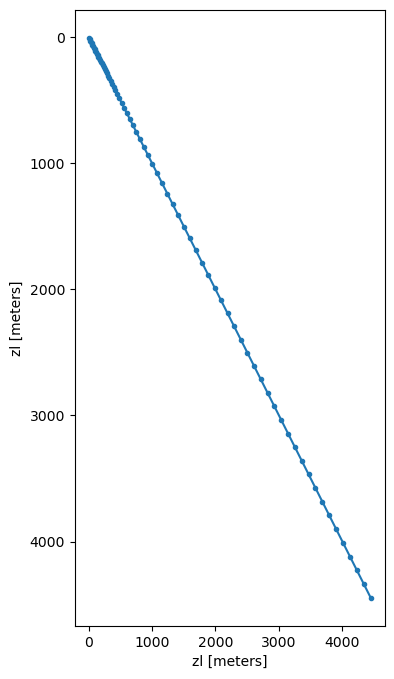

In [9]:
expt.vgrid.zl.plot(marker = '.',
                   y='zl',
                   yincrease=False,
                   figsize=(4, 8))

### Modular workflow!

After constructing your `expt` object, if you don't like the default `hgrid` and `vgrid` you can simply modify and then save them back into the `expt` object. However, you'll then also need to save them to disk again. For example:

```python
new_hgrid = xr.open_dataset(input_dir + "/hgrid.nc")
```
Modify `new_hgrid`, ensuring that _all metadata_ is retained to keep MOM6 happy. Then, save your changes

```python
expt.hgrid = new_hgrid

expt.hgrid.to_netcdf(input_dir + "/hgrid.nc")
```

## Step 4: Set up bathymetry

Similarly to ocean forcing, we point the experiment's `setup_bathymetry` method at the location of the file of choice and also provide the variable names. We don't need to preprocess the bathymetry since it is simply a two-dimensional field and is easier to deal with. Afterwards you can inspect `expt.bathymetry` to have a look at the regional domain.

After running this cell, your input directory will contain other bathymetry-related things like the ocean mosaic and mask table too. The mask table defaults to a 10x10 layout and can be modified later.

In [10]:
expt.setup_bathymetry(
    bathymetry_path='/g/data/ik11/inputs/GEBCO_2022/GEBCO_2022.nc',
    longitude_coordinate_name='lon',
    latitude_coordinate_name='lat',
    vertical_coordinate_name='elevation',
    )

INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder


Begin regridding bathymetry...

Original bathymetry size: 37.08 Mb
Regridded size: 0.84 Mb
Automatic regridding may fail if your domain is too big! If this process hangs or crashes,make sure function argument write_to_file = True and,open a terminal with appropriate computational and resources try calling ESMF directly in the input directory /scratch/x77/nc3020/regional_mom6_configs/tassie-access-om2-forced via

`mpirun -np NUMBER_OF_CPUS ESMF_Regrid -s bathymetry_original.nc -d bathymetry_unfinished.nc -m bilinear --src_var depth --dst_var depth --netcdf4 --src_regional --dst_regional`

For details see https://xesmf.readthedocs.io/en/latest/large_problems_on_HPC.html

Afterwards, we run the 'expt.tidy_bathymetry' method to skip the expensive interpolation step, and finishing metadata, encoding and cleanup.



Regridding successful! Now calling `tidy_bathymetry` method for some finishing touches...
setup bathymetry has finished successfully.
Tidy bathymetry: Reading in regridded bathym

<xarray.Dataset> Size: 837kB
Dimensions:  (ny: 249, nx: 140)
Coordinates:
    lon      (ny, nx) float64 279kB 143.0 143.1 143.1 ... 149.9 149.9 150.0
    lat      (ny, nx) float64 279kB -47.98 -47.98 -47.98 ... -38.97 -38.97
Dimensions without coordinates: ny, nx
Data variables:
    depth    (ny, nx) float64 279kB 4.584e+03 4.552e+03 ... 4.215e+03 4.364e+03
Attributes:
    depth:          meters
    standard_name:  bathymetric depth at T-cell centers
    coordinates:    zi

### Check out your domain:

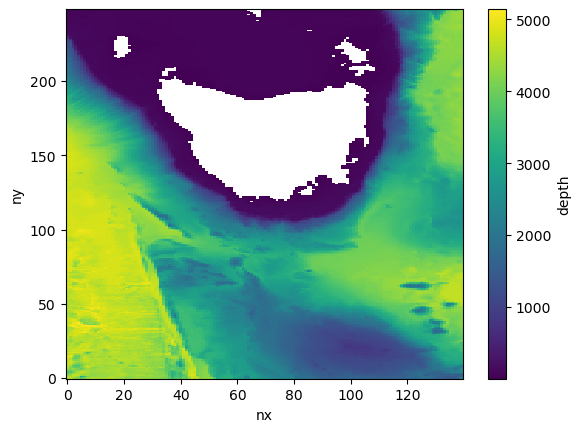

In [11]:
expt.bathymetry.depth.plot()

##  Step 5: Handle the ocean forcing - where the magic happens

This cuts out and interpolates the initDefine a mapping from MOM5's B grid variables and dimensions to MOM6's C grid onesial condition as well as all boundaries (unless you don't pass it boundaries).

The dictionary maps the MOM6 variable names to what they're called in your ocean input file. Notice how the horizontal dimensions are `xt_ocean`, `yt_ocean`, `xu_ocean`, `yu_ocean` in ACCESS-OM2-01 versus `xh`, `yh`, `xq`, and `yq` in MOM6. This is because ACCESS-OM2-01 is on a `B` grid, so we need to differentiate between `q` and `t` points. 

If one of your segments is land, you can delete its string from the 'boundaries' list. You'll need to update `MOM_input` to reflect this though so it knows how many segments to look for, and their orientations. 

Define a mapping from the MOM5 B grid variables and dimensions to the MOM6 C grid ones

In [12]:
ocean_varnames = {"time": "time",
                  "yh": "yt_ocean",
                  "xh": "xt_ocean",
                  "xq": "xu_ocean",
                  "yq": "yu_ocean",
                  "zl": "st_ocean",
                  "eta": "eta_t",
                  "u": "u",
                  "v": "v",
                  "tracers": {"salt": "salt", "temp": "temp"}
                  }

Set up the initial condition

No `xu_ocean` and `xt_ocean` in **west_unprocessed.nc** and **east_unprocessed.nc**

`xu_ocean = UNLIMITED ; // (0 currently)`

In [13]:
expt.setup_initial_condition(
    tmp_dir + "/ic_unprocessed.nc", # directory where the unprocessed initial condition is stored, as defined earlier
    ocean_varnames,
    arakawa_grid="B"
    )

# Set up the four boundary conditions.
expt.setup_ocean_state_boundaries(
    Path(tmp_dir),
    ocean_varnames,
    arakawa_grid = "B"
    )


INFO:regional_mom6.regridding:Getting t points..
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder


Setting up Initial Conditions
Regridding Velocities... 

INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Getting u points..
INFO:regional_mom6.regridding:Getting v points..


Done.
Regridding Tracers... Done.
Regridding Free surface... Done.
Saving outputs... 

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle


done setting up initial condition.
Processing north boundary velocity & tracers...

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to temp_segment_001
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in u_segment_001
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to u_segment_001
INFO:regional_mo

Done.
Processing south boundary velocity & tracers...

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_003
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_003
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension

Done.
Processing east boundary velocity & tracers...

INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.regridding:Creating Regridder
INFO:regional_mom6.rotation:Getting rotation angle
INFO:regional_mom6.rotation:Calculating grid rotation angle
INFO:regional_mom6.regridding:Creating coordinates of the boundary q/u/v points
INFO:regional_mom6.regridding:Filling in missing data horizontally, then vertically
INFO:regional_mom6.regridding:Adding time dimension
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in salt_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension to salt_segment_004
INFO:regional_mom6.regridding:Renaming vertical coordinate to nz_... in temp_segment_004
INFO:regional_mom6.regridding:Replacing old depth coordinates with incremental integers
INFO:regional_mom6.regridding:Adding perpendicular dimension

Done.
Processing west boundary velocity & tracers...Done.


We can inspect all variable in the experiment by calling

In [14]:
vars(expt)

{'expt_name': None,
 'date_range': [datetime.datetime(2013, 1, 1, 0, 0),
  datetime.datetime(2013, 1, 5, 0, 0)],
 'mom_run_dir': PosixPath('/home/552/nc3020/mom6_rundirs/tassie-access-om2-forced'),
 'mom_input_dir': PosixPath('/scratch/x77/nc3020/regional_mom6_configs/tassie-access-om2-forced'),
 'fre_tools_dir': PosixPath('/g/data/ik11/mom6_tools/tools'),
 'resolution': 0.05,
 'number_vertical_layers': 75,
 'layer_thickness_ratio': 10,
 'depth': 4500,
 'hgrid_type': 'even_spacing',
 'vgrid_type': 'hyperbolic_tangent',
 'repeat_year_forcing': False,
 'ocean_mask': <xarray.DataArray 'depth' (ny: 249, nx: 140)> Size: 279kB
 array([[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1]])
 Coordinates:
     lon      (ny, nx) float64 279kB 143.0 143.1 143.1 ... 149.9 149.9 150.0
     lat      (ny, nx) float64 279kB -47.98 -47.98 -47.98 ... -38.97

Furthermore, we can plot our the interpolated initial condition. It's a good idea to check and ensure things look reasonble, especially near the region's boundaries.

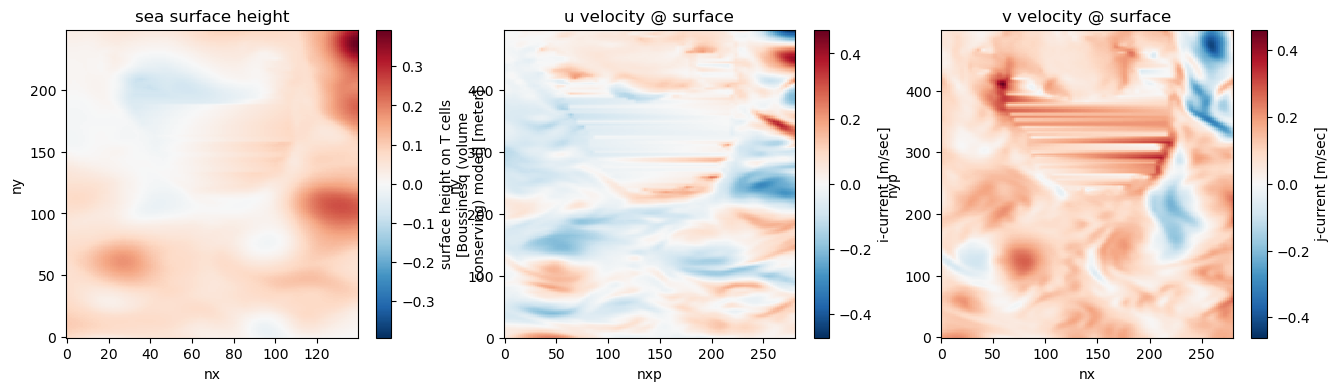

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

expt.ic_eta.plot(ax=axes[0])
expt.ic_vels.u.sel(zl=0, method='nearest').plot(ax=axes[1])
expt.ic_vels.v.sel(zl=0, method='nearest').plot(ax=axes[2])

axes[0].set_title("sea surface height")
axes[1].set_title("u velocity @ surface")
axes[2].set_title("v velocity @ surface");

To ensure that no spurious gradients have emerged at the boundaries (e.g., during the interpolation) we plot a few slices, e.g.,

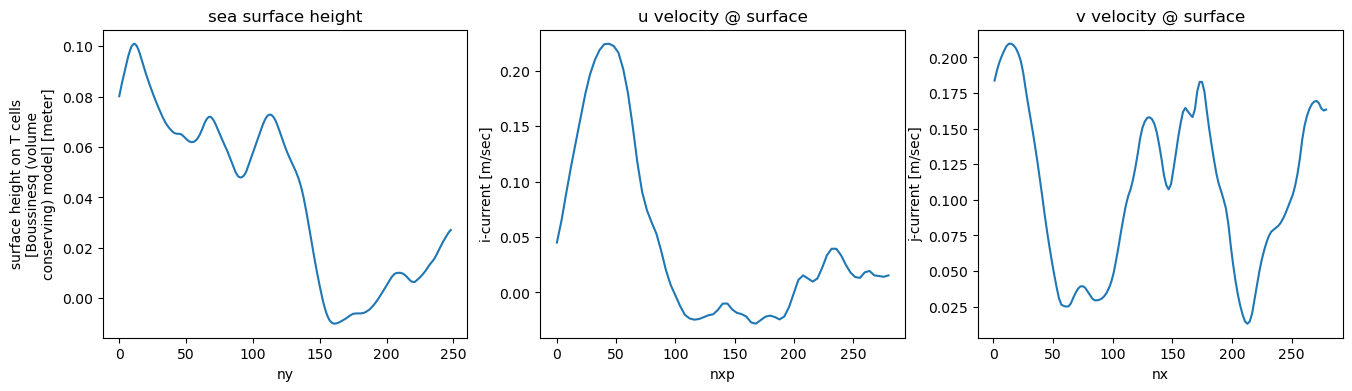

In [16]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))

expt.ic_eta.isel(nx=0).plot(ax=axes[0])
expt.ic_vels.u.isel(ny=0, zl=0).plot(ax=axes[1])
expt.ic_vels.v.isel(nyp=0, zl=0).plot(ax=axes[2])

axes[0].set_title("sea surface height")
axes[1].set_title("u velocity @ surface")
axes[2].set_title("v velocity @ surface");

## Step 6: Run the FRE tools

This is just a wrapper for the FRE tools needed to make the mosaics and masks for the experiment. The only thing you need to tell it is the processor layout. In this case we're asking for a 10 by 10 grid of 100 processors.

In [17]:
expt.run_FRE_tools(layout = (10, 10)) ## Here the tuple defines the processor layout

Running GFDL's FRE Tools. The following information is all printed by the FRE tools themselves
NOTE from make_solo_mosaic: there are 0 contacts (align-contact)
congradulation: You have successfully run make_solo_mosaic
OUTPUT FROM MAKE SOLO MOSAIC:

CompletedProcess(args='/g/data/ik11/mom6_tools/tools/make_solo_mosaic/make_solo_mosaic --num_tiles 1 --dir . --mosaic_name ocean_mosaic --tile_file hgrid.nc', returncode=0)


cp: './ocean_mosaic.nc' and 'ocean_mosaic.nc' are the same file
cp: './hgrid.nc' and 'hgrid.nc' are the same file


cp ./hgrid.nc hgrid.nc 

NOTE from make_coupler_mosaic: the ocean land/sea mask will be determined by field depth from file bathymetry.nc
mosaic_file is grid_spec.nc

***** Congratulation! You have successfully run make_quick_mosaic
OUTPUT FROM QUICK MOSAIC:

CompletedProcess(args='/g/data/ik11/mom6_tools/tools/make_quick_mosaic/make_quick_mosaic --input_mosaic ocean_mosaic.nc --mosaic_name grid_spec --ocean_topog bathymetry.nc', returncode=0)

 ===>NOTE from check_mask: when layout is specified, min_pe and max_pe is set to layout(1)*layout(2)=100

 ===>NOTE from check_mask: Below is the list of command line arguments.

grid_file = ocean_mosaic.nc
topog_file = bathymetry.nc
min_pe = 100
max_pe = 100
layout = 10, 10
halo = 4
sea_level = 0
show_valid_only is not set
nobc = 0

 ===>NOTE from check_mask: End of command line arguments.

 ===>NOTE from check_mask: the grid file is version 2 (mosaic grid) grid which contains field gridfiles

==>NOTE from get_boundary_type: x_boundary_type is 

## Step 7: Modify the default input directory to make a runnable configuration out of the box

This step copies the default directory, and modifies the `MOM_layout` files to match your experiment by inserting the right number of x, y points and cpu layout. If you use Payu to run MOM6, set the `using_payu` flag to `True` and an example `config.yaml` file will be copied to your run directory. This still needs to be modified manually to work with your projects, executable etc.

In [18]:
expt.setup_run_directory(surface_forcing = "jra", using_payu = True)

Mask table mask_table.2.10x10 read. Using this to infer the cpu layout (10, 10), total masked out cells 2, and total number of CPUs 98.
Deleting indexed OBC keys from MOM_input_dict in case we have a different number of segments


## Step 8: Run your model!

To do this, navigate to your run directory in terminal. If you're working on NCI, you can run your model via:

```
module load conda/analysis3
payu setup -f
payu run -f
```

By default `input.nml` is set to only run for 5 days as a test. If this is successful, you can modify this file to then run for longer.

## Step 9 and beyond: Fiddling, troubleshooting, and fine tuning

Hopefully our model is running. If not, the first thing you should do is reduce the timestep. You can do this by adding `#override DT=XXXX` to your `MOM_override` file. 

If there's strange behaviour on your boundaries, you could play around with the `nudging timescale` (an example is already included in the `MOM_override` file). Sometimes, if your boundary has a lot going on (like all of the eddies spinning off the western boundary currents or off the Antarctic Circumpolar current), it can be hard to avoid these edge effects. This is because the chaotic, submesoscale structures developed within the regional domain won't match those at the boundary.

Another thing that can go wrong is little bays creating non-advective cells at your boundaries. Keep an eye out for tiny bays where one side is taken up by a boundary segment. You can either fill them in manually, or move your boundary slightly to avoid them

In [19]:
client.close()